# Import Librarys

In [1]:
import project
import pandas                   as pd
import numpy                    as np
import scikitplot               as skplt
from sklearn.model_selection    import StratifiedKFold
from sklearn                    import linear_model as lm

# Load the data

In [2]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

df5 = pd.read_csv('../data/dataframe_steps/df5.csv')
x_val = pd.read_csv('../data/dataframe_steps/x_val_pp.csv')

x_train = df5[ cols_selected ]
y_train = df5['response']

x_val1 = x_val[ cols_selected ]
y_val = pd.read_csv('../data/dataframe_steps/y_val.csv')

In [3]:
# append dataframes for cross-validation
cv_x = pd.concat([x_train, x_val1])
cv_y = pd.concat([pd.DataFrame(y_train), y_val])

# dataset for cross validation
dataset = cv_x
dataset['response'] = cv_y

k = int(x_val.shape[0]*0.4)

# Logistic Regressio Model

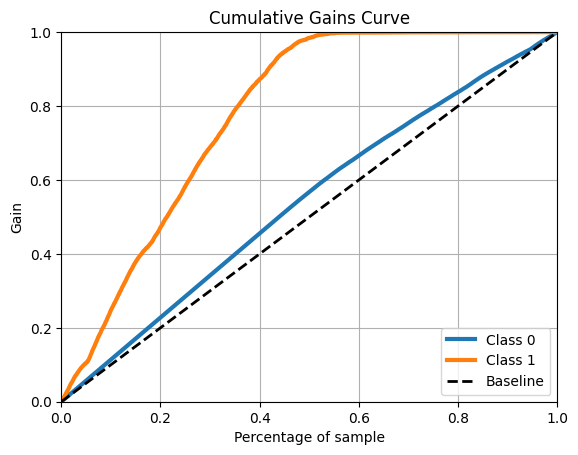

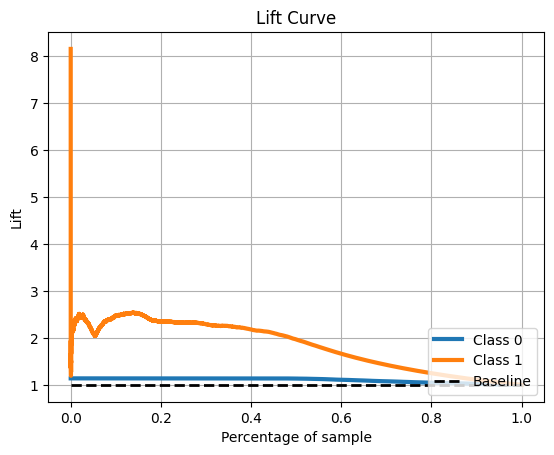

In [4]:
# model definition
lr_model = lm.LogisticRegression()

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val1 )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

# Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr);

In [5]:
insurance = project.ProjectFunctions()
lr_score = insurance.make_score(x_val, y_val, yhat_lr)

# compute precision at K
precision_at_n_k = insurance.precision_at_k( lr_score, k=k )
print( f'Precision at K: {precision_at_n_k}' )

# compute recall at K
recall_at_n_k = insurance.recall_at_k( lr_score, k=k )
print( f'Recall    at K: {recall_at_n_k}')

Precision at K: 0.2674407163239201
Recall    at K: 0.8728323699421965


In [47]:
skf = StratifiedKFold(n_splits=10)

model = lr_model

lr_cv = insurance.stratifield_cross_validation( x_data=cv_x, y_data=cv_y,dataset=dataset, skf=skf, model=model, sample_size=0.4)

fold :1 | precision 0.26815 | recall 0.87519
fold :2 | precision 0.26756 | recall 0.87326
fold :3 | precision 0.26625 | recall 0.86898
fold :4 | precision 0.26756 | recall 0.87326
fold :5 | precision 0.26553 | recall 0.86662
fold :6 | precision 0.26632 | recall 0.86919
fold :7 | precision 0.26691 | recall 0.87112
fold :8 | precision 0.26809 | recall 0.87497
fold :9 | precision 0.26907 | recall 0.87818
fold :10 | precision 0.26573 | recall 0.86727


# Hyperparameter Finetunning

In [12]:
# n_samples / (n_classes * np.bincount(y))
x_train.shape[0] / (2*np.bincount(y_train))

array([0.56984177, 4.07951991])

In [7]:
from skopt import dummy_minimize

In [23]:
mdl = lm.LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='saga', l1_ratio=1)
mdl.fit( x_train, y_train )

/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


LogisticRegression(C=0.1, l1_ratio=1, solver='saga')

In [30]:
def training_model(params):
    penalty = params[0]
    C = params[1]
    class_weight = params[2]
    solver = params[3] 
    l1_ratio = params[4] 
    
    print(params, '\n')
    
    mdl = lm.LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, solver=solver, 
                                l1_ratio=l1_ratio, random_state=0)
    mdl.fit(x_train, y_train)
    
    p = mdl.predict_proba(x_val1)[:,1]
    
    data = x_val1.copy()
    data['response'] = y_val.copy()
    data['score'] = p.tolist()
    data = data.sort_values('score', ascending=False)
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    precision = data.loc[k, 'precision_at_k']
    
    return -precision

In [34]:
space = [['l2', 'l1', 'elasticnet'], # penalty
         [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], # C
         ['balanced', None], # class_weight
         ['saga'], # solver
         (0, 1)] # l1_ratio

In [35]:
resultado = dummy_minimize(training_model, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
['elasticnet', 1000, 'balanced', 'saga', 0] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.7570
Function value obtained: -0.2681
Current minimum: -0.2681
Iteration No: 2 started. Evaluating function at random point.
['l2', 0.001, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.2540
Function value obtained: -0.2694
Current minimum: -0.2694
Iteration No: 3 started. Evaluating function at random point.
['elasticnet', 0.01, None, 'saga', 0] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.6083
Function value obtained: -0.2700
Current minimum: -0.2700
Iteration No: 4 started. Evaluating function at random point.
['l2', 10, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.7036
Function value obtained: -0.2681
Current minimum: -0.2700
Iteration No: 5 started. Evaluating function at random point.
['elasticnet', 100, None, 'saga', 1] 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 7.4482
Function value obtained: -0.2672
Current minimum: -0.2700
Iteration No: 6 started. Evaluating function at random point.
['elasticnet', 1000, None, 'saga', 1] 

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 7.4883
Function value obtained: -0.2672
Current minimum: -0.2700
Iteration No: 7 started. Evaluating function at random point.
['l2', 0.0001, None, 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.2290
Function value obtained: -0.2551
Current minimum: -0.2700
Iteration No: 8 started. Evaluating function at random point.
['elasticnet', 1, None, 'saga', 0] 

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 7.0719
Function value obtained: -0.2674
Current minimum: -0.2700
Iteration No: 9 started. Evaluating function at random point.
['elasticnet', 0.1, 'balanced', 'saga', 0] 

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.5023
Function value obtained: -0.2692
Current minimum: -0.2700
Iteration No: 10 started. Evaluating function at random point.
['elasticnet', 0.01, None, 'saga', 0] 

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.7151
Function value obtained: -0.2700
Current minimum: -0.2700
Iteration No: 11 started. Evaluating function at random point.
['l1', 0.0001, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 1.3952
Function value obtained: -0.2487
Current minimum: -0.2700
Iteration No: 12 started. Evaluating function at random point.
['l2', 10, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 4.7664
Function value obtained: -0.2681
Current minimum: -0.2700
Iteration No: 13 started. Evaluating function at random point.
['l1', 1, None, 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 7.6812
Function value obtained: -0.2673
Current minimum: -0.2700
Iteration No: 14 started. Evaluating function at random point.
['elasticnet', 0.0001, 'balanced', 'saga', 1] 

Iteration No: 14 ended. Evaluation done at random point.
Time taken: 1.4625
Function value obtained: -0.2487
Current minimum: -0.2700
Iteration No: 15 started. Evaluating function at random point.
['l1', 100, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 5.0590
Function value obtained: -0.2681
Current minimum: -0.2700
Iteration No: 16 started. Evaluating function at random point.
['elasticnet', 1, None, 'saga', 0] 

Iteration No: 16 ended. Evaluation done at random point.
Time taken: 7.2324
Function value obtained: -0.2674
Current minimum: -0.2700
Iteration No: 17 started. Evaluating function at random point.
['elasticnet', 0.1, None, 'saga', 1] 

Iteration No: 17 ended. Evaluation done at random point.
Time taken: 7.7072
Function value obtained: -0.2676
Current minimum: -0.2700
Iteration No: 18 started. Evaluating function at random point.
['l1', 100, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 7.6694
Function value obtained: -0.2672
Current minimum: -0.2700
Iteration No: 19 started. Evaluating function at random point.
['l1', 0.01, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 6.8836
Function value obtained: -0.2685
Current minimum: -0.2700
Iteration No: 20 started. Evaluating function at random point.
['l1', 1000, None, 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 7.8365
Function value obtained: -0.2672
Current minimum: -0.2700
Iteration No: 21 started. Evaluating function at random point.
['elasticnet', 0.0001, 'balanced', 'saga', 0] 

Iteration No: 21 ended. Evaluation done at random point.
Time taken: 1.2889
Function value obtained: -0.2624
Current minimum: -0.2700
Iteration No: 22 started. Evaluating function at random point.
['l2', 1000, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 22 ended. Evaluation done at random point.
Time taken: 7.1413
Function value obtained: -0.2672
Current minimum: -0.2700
Iteration No: 23 started. Evaluating function at random point.
['l2', 1, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 23 ended. Evaluation done at random point.
Time taken: 4.6574
Function value obtained: -0.2684
Current minimum: -0.2700
Iteration No: 24 started. Evaluating function at random point.
['elasticnet', 1, 'balanced', 'saga', 1] 

Iteration No: 24 ended. Evaluation done at random point.
Time taken: 5.0737
Function value obtained: -0.2681
Current minimum: -0.2700
Iteration No: 25 started. Evaluating function at random point.
['l1', 0.0001, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 25 ended. Evaluation done at random point.
Time taken: 1.4092
Function value obtained: -0.2487
Current minimum: -0.2700
Iteration No: 26 started. Evaluating function at random point.
['elasticnet', 0.0001, None, 'saga', 0] 

Iteration No: 26 ended. Evaluation done at random point.
Time taken: 1.2262
Function value obtained: -0.2551
Current minimum: -0.2700
Iteration No: 27 started. Evaluating function at random point.
['l2', 1, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 27 ended. Evaluation done at random point.
Time taken: 4.6362
Function value obtained: -0.2684
Current minimum: -0.2700
Iteration No: 28 started. Evaluating function at random point.
['l2', 0.001, None, 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 28 ended. Evaluation done at random point.
Time taken: 1.2654
Function value obtained: -0.2676
Current minimum: -0.2700
Iteration No: 29 started. Evaluating function at random point.
['elasticnet', 0.01, 'balanced', 'saga', 0] 

Iteration No: 29 ended. Evaluation done at random point.
Time taken: 3.1661
Function value obtained: -0.2709
Current minimum: -0.2709
Iteration No: 30 started. Evaluating function at random point.
['elasticnet', 1, 'balanced', 'saga', 1] 

Iteration No: 30 ended. Evaluation done at random point.
Time taken: 5.1638
Function value obtained: -0.2681
Current minimum: -0.2709


In [36]:
resultado.x

['elasticnet', 0.01, 'balanced', 'saga', 0]

0.2709
['elasticnet', 0.01, 'balanced', 'saga', 0]

In [38]:
from skopt import gp_minimize

In [39]:
resultados_gp = gp_minimize(training_model, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
['l2', 1000.0, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.9151
Function value obtained: -0.2681
Current minimum: -0.2681
Iteration No: 2 started. Evaluating function at random point.
['l1', 0.1, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.6694
Function value obtained: -0.2676
Current minimum: -0.2681
Iteration No: 3 started. Evaluating function at random point.
['l1', 1.0, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.1066
Function value obtained: -0.2681
Current minimum: -0.2681
Iteration No: 4 started. Evaluating function at random point.
['l2', 0.1, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.5418
Function value obtained: -0.2692
Current minimum: -0.2692
Iteration No: 5 started. Evaluating function at random point.
['l1', 100.0, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.0946
Function value obtained: -0.2681
Current minimum: -0.2692
Iteration No: 6 started. Evaluating function at random point.
['l2', 100.0, 'balanced', 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 4.8832
Function value obtained: -0.2681
Current minimum: -0.2692
Iteration No: 7 started. Evaluating function at random point.
['l1', 10.0, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 5.0869
Function value obtained: -0.2681
Current minimum: -0.2692
Iteration No: 8 started. Evaluating function at random point.
['elasticnet', 10.0, 'balanced', 'saga', 1] 

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 5.1184
Function value obtained: -0.2681
Current minimum: -0.2692
Iteration No: 9 started. Evaluating function at random point.
['l1', 0.01, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.9220
Function value obtained: -0.2693
Current minimum: -0.2693
Iteration No: 10 started. Evaluating function at random point.
['l1', 0.001, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 1.8665
Function value obtained: -0.2527
Current minimum: -0.2693
Iteration No: 11 started. Searching for the next optimal point.
['l1', 1000.0, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.2491
Function value obtained: -0.2672
Current minimum: -0.2693
Iteration No: 12 started. Searching for the next optimal point.
['elasticnet', 10.0, None, 'saga', 0] 

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 7.7142
Function value obtained: -0.2672
Current minimum: -0.2693
Iteration No: 13 started. Searching for the next optimal point.
['l1', 0.0001, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.9517
Function value obtained: -0.2487
Current minimum: -0.2693
Iteration No: 14 started. Searching for the next optimal point.
['l2', 0.01, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 4.1996
Function value obtained: -0.2700
Current minimum: -0.2700
Iteration No: 15 started. Searching for the next optimal point.
['elasticnet', 100.0, None, 'saga', 0] 

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 7.5406
Function value obtained: -0.2672
Current minimum: -0.2700
Iteration No: 16 started. Searching for the next optimal point.
['elasticnet', 0.01, 'balanced', 'saga', 0] 

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 3.4975
Function value obtained: -0.2709
Current minimum: -0.2709
Iteration No: 17 started. Searching for the next optimal point.
['elasticnet', 1.0, None, 'saga', 0] 

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 7.4410
Function value obtained: -0.2674
Current minimum: -0.2709
Iteration No: 18 started. Searching for the next optimal point.
['elasticnet', 0.01, None, 'saga', 0] 

/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 5.0061
Function value obtained: -0.2684
Current minimum: -0.2709
Iteration No: 22 started. Searching for the next optimal point.
['l2', 0.1, None, 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.8371
Function value obtained: -0.2680
Current minimum: -0.2709
Iteration No: 23 started. Searching for the next optimal point.
['elasticnet', 0.01, 'balanced', 'saga', 1] 

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 5.1258
Function value obtained: -0.2693
Current minimum: -0.2709
Iteration No: 24 started. Searching for the next optimal point.
['l2', 10.0, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 7.5112
Function value obtained: -0.2672
Current minimum: -0.2709
Iteration No: 25 started. Searching for the next optimal point.
['l2', 1000.0, None, 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 7.4608
Function value obtained: -0.2672
Current minimum: -0.2709
Iteration No: 26 started. Searching for the next optimal point.
['l2', 0.001, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 1.7186
Function value obtained: -0.2694
Current minimum: -0.2709
Iteration No: 27 started. Searching for the next optimal point.
['elasticnet', 0.0001, 'balanced', 'saga', 0] 

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 1.7188
Function value obtained: -0.2624
Current minimum: -0.2709
Iteration No: 28 started. Searching for the next optimal point.
['l2', 0.0001, None, 'saga', 1] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.7157
Function value obtained: -0.2551
Current minimum: -0.2709
Iteration No: 29 started. Searching for the next optimal point.
['elasticnet', 0.001, 'balanced', 'saga', 0] 

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 1.8100
Function value obtained: -0.2694
Current minimum: -0.2709
Iteration No: 30 started. Searching for the next optimal point.
['l2', 0.01, 'balanced', 'saga', 0] 



/home/mars/.pyenv/versions/3.10.0/envs/PA004/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.5753
Function value obtained: -0.2709
Current minimum: -0.2709


In [40]:
resultados_gp.x

['elasticnet', 0.01, 'balanced', 'saga', 0]

0.2709
['elasticnet', 0.01, 'balanced', 'saga', 0]


In [41]:
from skopt.plots import plot_convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

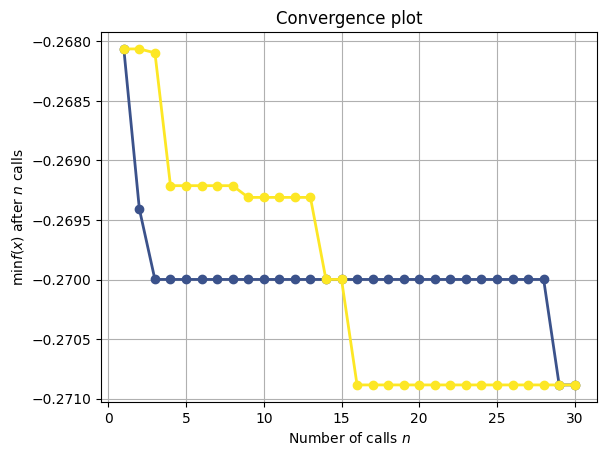

In [42]:
plot_convergence(resultado, resultados_gp)

# CV with the best parameters

In [ ]:
['elasticnet', 0.01, 'balanced', 'saga', 0]

In [46]:
skf = StratifiedKFold(n_splits=10)

model = lm.LogisticRegression(penalty='elasticnet', C=0.01, class_weight='balanced', solver='saga', 
                                l1_ratio=0, random_state=0)

lr_tunning = insurance.stratifield_cross_validation( x_data=cv_x, y_data=cv_y,dataset=dataset, skf=skf, model=model, sample_size=0.4)

fold :1 | precision 0.27156 | recall 0.88632
fold :2 | precision 0.27051 | recall 0.88289
fold :3 | precision 0.2694 | recall 0.87925
fold :4 | precision 0.27268 | recall 0.88996
fold :5 | precision 0.26881 | recall 0.87733
fold :6 | precision 0.26986 | recall 0.88075
fold :7 | precision 0.27038 | recall 0.88247
fold :8 | precision 0.27038 | recall 0.88247
fold :9 | precision 0.27242 | recall 0.8891
fold :10 | precision 0.26947 | recall 0.87947


In [48]:
lr_cv

{1: [0.2681534929485077, 0.8751873260543781],
 2: [0.2675631354542473, 0.873260543780775],
 3: [0.2662512299114464, 0.8689788053949904],
 4: [0.2675631354542473, 0.873260543780775],
 5: [0.2655296818629059, 0.8666238492828088],
 6: [0.2663168251885864, 0.8691928923142797],
 7: [0.26690718268284686, 0.8711196745878826],
 8: [0.26808789767136765, 0.8749732391350888],
 9: [0.26907182682846836, 0.8781845429244273],
 10: [0.265726467694326, 0.8672661100406766]}

In [49]:
lr_tunning

{1: [0.2715644473597901, 0.8863198458574181],
 2: [0.27051492292554935, 0.8828944551487904],
 3: [0.26939980321416857, 0.8792549775208734],
 4: [0.27267956707117086, 0.889959323485335],
 5: [0.26880944571990817, 0.8773281952472703],
 6: [0.2698589701541489, 0.8807535859558981],
 7: [0.2703837323712693, 0.882466281310212],
 8: [0.2703837323712693, 0.882466281310212],
 9: [0.2724171859626107, 0.8891029758081781],
 10: [0.2694653984913086, 0.8794690644401627]}